# Data Visualiztion Course Final Projet
> by Kfir Goldfarb

<a href="https://github.com/kggold4"><img src="images/github.png" width="25px" height="25px" align="left"></a>
<a href="https://www.linkedin.com/in/kfir-goldfarb/"><img src="images/in.png"  width="25px" height="25px" align="left"></a>
<a href="mailto:kfir.goldfarb@msmail.ariel.ac.il"><img src="images/email.png" width="25px" height="25px" align="left"></a>
<a href="https://www.youtube.com/channel/UCypEWlruyG_I5A48GqB5c6g"><img src="images/youtube.png" width="25px" height="25px" align="left"></a>
<a href="https://www.hackerrank.com/kggold4?hr_r=1"><img src="images/hackerrank.png" width="25px" height="25px" align="left"></a>
<a href="https://stackoverflow.com/users/14749277/kfir-goldfarb"><img src="images/stackoverflow.png" width="25px" height="25px" align="left"></a>


<br>

# Jupyter Notebook Number 4
<i>Classification using ensemble and usupervised learning on the Hands datasets</i>

In [1]:
# Data Science libraries
import pandas as pd
import numpy as np

# Graphical libraries
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly.offline as py
import seaborn as sns
import cv2

# Main libraries
import os
import math
import random
import warnings
from zipfile import ZipFile as zf
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# sklearn tools
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# basic models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

# ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

### <i>Helping Functions I Wrote:</i>

In [2]:
# function that print the accuracy of a classification model
def print_accuracy(clf, X_train, X_test, y_train, y_test):
    # fit the train data to the model
    clf.fit(X_train, y_train)

    # get the pridictions of X_test
    pridictions = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)
    probabilities = probabilities[:, 1]

    # get the accuracy of the model
    accuracy = clf.score(X_test, y_test)

    # print the accuracy
    print(classification_report(y_test, pridictions))
    print('accuracy of the model is: {} %'.format("%.2f" % (accuracy * 100)))
    return accuracy

In [3]:
# function of ploting the confusion_matrix
def my_plot_confusion_matrix(clf, X_test, y_test):

    # get the confusion_matrix for ploting
    matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)

    # main title
    matrix.ax_.set_title('Confusion matrix')

    # x label
    plt.xlabel('Predicted Label')

    # y label
    plt.ylabel('True label')

    # size of the figure
    plt.gcf().set_size_inches(10, 6)

    # show plot
    plt.show()

### <i>Declare paths and directories of data:</i>

In [4]:
# first creating the paths of files
# paths
TRAIN_PATH ='data/task_4/Training'
VALID_PATH ='data/task_4/Validation'
RIGHT_HAND_PATH = 'data/task_4/HandRight.csv'

# list of directories
TRAIN_DIR = os.listdir(TRAIN_PATH)
VALID_DIR = os.listdir(VALID_PATH)

### <i>Creating data frame helping function:</i>

In [5]:
def create_data_frame(PATH, f):
    
    PATH += f
    
    # read the path csv
    result_data_frame = pd.read_csv(PATH)
    
    # taking only the drop time and append 7 to it (celi rounded)
    drop_time = result_data_frame["Time"][0]
    drop_time = math.ceil(drop_time) + 7
    
    # mark True or False if drop time is less then the Time in the dataframe
    result_data_frame = result_data_frame[result_data_frame["Time"] > drop_time]
    
    # if the data is Alone merge it with the right hand data
    if 'Alone' in PATH:
        
        # right hand data
        right_data = pd.read_csv(RIGHT_HAND_PATH)
        right_data = right_data.drop(columns=[' # hands','Time'], axis=1)
        right_data = right_data[right_data[' Hand Type'] == 'right']
        right_data = right_data.drop([' Frame ID'], axis=1)
        
        # result data
        result_data_frame.insert(loc=1, column='label', value=0)
        result_data_frame = result_data_frame[result_data_frame[' Hand Type'] == 'left']
        result_data_frame = result_data_frame.drop(columns = ' # hands', axis=1)
        
        right_data = right_data.iloc[:len(result_data_frame)]
        right_data = right_data.reset_index(drop=True)
        
        result_data_frame = result_data_frame.reset_index(drop=True)
        
        # merge left data with right hand
        result_data_frame = pd.merge(result_data_frame, right_data, left_index=True, right_index=True, how='left')
    
    # if data is not Alone
    else:
        
        # result data
        result_data_frame = result_data_frame[result_data_frame[' # hands'] == 2]
        result_data_frame = result_data_frame.drop(columns=' # hands', axis=1)
        
        # Sync state - value = 1
        if 'Sync' in f:
            result_data_frame.insert(loc=1, column='label', value=1)
        
        # Spontan state - value = 2
        if 'Spontan' in f:
            result_data_frame.insert(loc=1, column='label', value=2)
        
        # left hand data
        left_hand = result_data_frame[result_data_frame[' Hand Type'] == 'left']
        left_hand.reset_index(drop=True,inplace=True)
        
        # right hand data
        right_hand = result_data_frame[result_data_frame[' Hand Type'] == 'right']
        right_hand.reset_index(drop=True,inplace=True)
        
        # merge inner the data of left and right hands
        result_data_frame = pd.merge(left_hand, right_hand, how='inner', on=["Time"," Frame ID","label"])  
    
    # dropna from the resukt data frame
    result_data_frame = result_data_frame.dropna()
    
    # order indexes
    result_data_frame = result_data_frame[result_data_frame.index % 10 == 9]
    
    # returning the result data frame
    return result_data_frame

### <i>Creating data frame for each file from directories helping function:</i>

In [6]:
def create_data_file(DIR, PATH):
    data = pd.DataFrame()
    for d in DIR:
        for f in os.listdir(PATH + '/' + d):
            data = pd.concat([data, create_data_frame(PATH + '/' + d + '/', f)])
    return data

## Creating the datasets

In [7]:
pd.set_option("display.max_columns", None)

# train data
train_data = create_data_file(TRAIN_DIR, TRAIN_PATH)
train_data.reset_index(drop=True, inplace=True)
train_data = train_data.drop(columns=' Frame ID')
train_data[" Hand Type_x"] = train_data[" Hand Type_x"].replace({'left': 0, 'right': 1})
train_data[" Hand Type_y"] = train_data[" Hand Type_y"].replace({'left': 0, 'right': 1})

# test data
validation_data = create_data_file(VALID_DIR, VALID_PATH)
validation_data.reset_index(drop=True, inplace=True)
validation_data = validation_data.drop(columns=' Frame ID')
validation_data[" Hand Type_x"] = validation_data[" Hand Type_x"].replace({'left': 0, 'right': 1})
validation_data[" Hand Type_y"] = validation_data[" Hand Type_y"].replace({'left': 0, 'right': 1})

In [8]:
# print first and last five row of data from the train data
train_data

,Time,label,Hand Type_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,Yaw_x,Wrist Pos X_x,Wrist Pos Y_x,Wrist Pos Z_x,Elbow pos X_x,Elbow Pos Y_x,Elbow Pos Z_x,Grab Strenth_x,Grab Angle_x,Pinch Strength_x,Hand Type_y,Position X_y,Position Y_y,Position Z_y,Velocity X_y,Velocity Y_y,Velocity Z_y,Pitch_y,Roll_y,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,72.15956,2,0,-121.24060,252.9392,95.354560,46.454280,176.90930,-127.551700,2.094281,0.909908,2.262713,-160.6761,205.7428,60.94947,-344.2899,39.13676,19.121140,0.0,0.234270,0.0,1,156.13640,244.8633,35.487560,-131.339400,-307.599400,-427.810900,1.099330,-0.828397,-0.804075,195.0933,190.0966,58.409920,344.9485,-8.030737,97.27179,0.174818,0.931012,0.000000
1,72.32529,2,0,-122.84900,288.1688,61.055950,-33.621280,152.62630,-196.186200,1.806412,1.012826,1.965955,-160.8068,232.3129,39.80321,-331.1181,50.72920,4.551410,0.0,0.000000,0.0,1,160.13630,217.7219,-14.002430,194.011600,66.919650,-140.443800,0.680988,-0.667480,-0.283197,185.5987,172.6180,34.299490,287.5720,-32.057450,138.84910,0.105680,1.055332,0.000000
2,72.49092,2,0,-124.08490,284.8572,32.389000,21.178400,-182.02250,-116.458500,1.568490,1.002146,1.567189,-165.8107,228.0243,24.17407,-326.5669,35.85951,2.928733,0.0,0.011735,0.0,1,176.39950,217.3663,-24.378570,-84.965180,-179.197400,-135.308500,0.532342,-0.550985,-0.064753,192.3955,178.7603,32.610070,298.7430,-15.851680,151.09050,1.000000,2.574331,0.495048
3,72.65702,2,0,-113.53730,241.1755,21.341920,86.057090,-368.90820,-72.339200,1.416377,0.804790,1.417277,-165.7322,193.0605,19.76737,-346.6534,18.80253,8.680803,0.0,0.161417,0.0,1,158.26190,170.7646,-44.450270,-113.102200,-331.916700,-64.353660,0.220659,-0.154327,-0.142893,179.5042,154.3322,20.651390,303.8044,4.557657,179.83150,1.000000,3.141593,0.532123
4,72.82223,2,0,-107.17350,210.5420,19.581410,-6.578657,-42.38414,1.446589,1.311182,0.542547,1.413218,-169.8945,177.2384,19.71079,-381.9680,43.92625,-2.649421,0.0,0.790966,0.0,1,140.36730,137.8413,-57.687300,-68.430730,-15.388920,-79.860970,0.013765,0.015238,-0.341291,171.8971,139.1814,5.710413,287.9569,88.396980,222.96210,1.000000,3.141593,0.871786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17462,854.96330,1,0,-77.49830,203.5687,0.131859,-10.814190,-18.57390,-30.342760,1.160698,1.446287,0.526926,-100.6019,137.0079,18.79995,-259.9480,-61.06125,67.628750,0.0,0.000000,0.0,1,93.50794,203.4165,64.593100,-28.771890,-39.439640,-75.992630,1.704137,-1.258564,-1.956911,124.2334,139.1985,49.559330,302.6661,-48.311740,46.65322,0.000000,0.000000,0.000000
17463,855.29750,1,0,-69.73535,173.6106,-9.636310,89.935730,-103.46200,-100.806400,0.745136,1.842165,0.561537,-103.5082,123.0523,30.07202,-307.0649,-14.43307,111.737300,0.0,0.000000,0.0,1,95.34378,199.7245,29.060590,27.227350,-55.780950,-120.143700,0.879330,-1.362314,-0.492873,126.6420,142.7829,62.173500,309.9026,-33.919800,109.06180,0.000000,0.000000,0.000000
17464,855.63010,1,0,-65.73239,141.0708,-27.202770,15.374810,-123.08830,-30.936240,0.066835,2.252769,0.543214,-106.6226,125.1690,30.50176,-327.3424,31.80914,128.346100,0.0,0.217919,0.0,1,89.17965,176.7911,3.835321,-4.449042,-8.244484,-5.883242,0.292693,-1.432133,-0.511331,131.1354,150.2186,57.255950,342.4425,49.990230,168.20800,0.000000,0.000000,0.000000
17465,855.96320,1,0,-74.79743,153.2910,-26.888440,-41.611610,81.40286,75.331090,0.169517,2.229823,0.506308,-113.7308,131.7587,30.02425,-342.6624,40.08743,108.723200,0.0,0.000000,0.0,1,92.07137,184.3723,8.743074,20.418590,52.893900,24.778090,0.386781,-1.380658,-0.489832,132.3895,152.5022,60.446040,343.7888,41.397530,160.31040,0.000000,0.000000,0.000000


In [9]:
# print the shape of the train data
train_data.shape

(17467, 40)

In [10]:
# descrive the train data
train_data.describe()

,Time,label,Hand Type_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,Yaw_x,Wrist Pos X_x,Wrist Pos Y_x,Wrist Pos Z_x,Elbow pos X_x,Elbow Pos Y_x,Elbow Pos Z_x,Grab Strenth_x,Grab Angle_x,Pinch Strength_x,Hand Type_y,Position X_y,Position Y_y,Position Z_y,Velocity X_y,Velocity Y_y,Velocity Z_y,Pitch_y,Roll_y,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
count,17467.000000,17467.000000,17467.0,17467.00000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.0,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000,17467.000000
mean,419.992513,1.025534,0.0,-114.43951,205.085987,38.755529,-0.013009,-2.001715,0.142069,1.022839,0.690926,1.195518,-158.658619,167.450445,44.741355,-327.094867,8.655564,73.277291,0.119933,0.818503,0.189445,1.0,95.491969,217.746183,38.749074,-1.024812,-0.189963,-1.230212,0.819832,-0.619590,-0.704730,128.691630,179.373001,72.270642,272.876104,26.905815,182.161658,0.060297,0.508056,0.052593
std,183.066669,0.813004,0.0,54.89055,55.426795,52.614849,134.093964,214.155086,135.165066,1.006905,1.134235,0.816052,51.948164,49.588614,46.150738,62.843079,66.797388,65.685097,0.287332,0.908358,0.331914,0.0,61.644281,53.742283,52.288553,150.546784,247.923258,174.531509,0.602977,0.643977,0.618667,70.329692,49.120960,52.042330,95.102111,59.611525,99.239094,0.208890,0.669309,0.189733
min,60.157540,0.000000,0.0,-363.16560,53.981950,-175.192200,-1567.891000,-1937.777000,-1163.047000,-3.137611,-3.141445,-3.139498,-380.106200,-12.279810,-134.610200,-542.893500,-227.942600,-269.460400,0.000000,0.000000,0.000000,1.0,-175.975100,67.079280,-152.239200,-1357.931000,-1337.625000,-1206.326000,-3.133817,-3.129433,-3.058076,-137.981800,11.438540,-133.890900,-24.711150,-209.569100,-71.755200,0.000000,0.000000,0.000000
25%,283.313150,0.000000,0.0,-145.36040,165.792500,6.753274,-66.386090,-110.847500,-61.065635,0.683298,0.205251,0.877463,-190.750950,135.075350,16.668770,-367.990650,-35.609645,24.285995,0.000000,0.007574,0.000000,1.0,40.195800,182.735300,2.179312,-53.380405,-117.076950,-75.752805,0.408390,-1.074991,-1.185751,58.181350,149.628200,33.076250,185.921800,-13.716765,103.229100,0.000000,0.063866,0.000000
50%,419.926600,1.000000,0.0,-107.96900,202.292500,38.109740,-1.628005,1.163112,1.490620,1.283631,0.838144,1.343030,-154.235800,162.628600,42.499160,-327.013500,1.952253,68.552170,0.000000,0.521585,0.000000,1.0,112.511700,214.473500,35.760530,0.284331,0.083143,-2.436140,0.807682,-0.606150,-0.602513,153.180500,173.244300,70.889940,300.711000,22.652370,161.265200,0.000000,0.289733,0.000000
75%,556.509250,2.000000,0.0,-80.26130,237.738900,71.510555,65.363570,111.905000,62.783765,1.631420,1.320071,1.650130,-122.477200,192.264350,70.573315,-288.222650,45.398710,121.993200,0.000000,1.262186,0.258382,1.0,142.220950,247.461000,69.954920,57.029725,110.807350,70.664380,1.284926,-0.065429,-0.184016,184.097100,204.020500,111.616800,347.540650,61.991810,257.787100,0.000000,0.629990,0.000000
max,856.295800,2.000000,0.0,73.48751,515.705200,269.505600,1814.025000,1357.658000,1852.240000,3.140376,3.141571,3.132029,22.004390,455.989400,245.962300,155.505700,398.001600,360.277900,1.000000,3.141593,1.000000,1.0,266.303800,444.691700,250.270300,1082.738000,939.483300,955.265100,3.117114,3.058548,3.105019,296.051100,406.522500,266.477000,503.235600,294.484200,518.347800,1.000000,3.141593,1.000000


In [11]:
# print first and last five row of data from the validation data
validation_data

,Time,label,Hand Type_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,Yaw_x,Wrist Pos X_x,Wrist Pos Y_x,Wrist Pos Z_x,Elbow pos X_x,Elbow Pos Y_x,Elbow Pos Z_x,Grab Strenth_x,Grab Angle_x,Pinch Strength_x,Hand Type_y,Position X_y,Position Y_y,Position Z_y,Velocity X_y,Velocity Y_y,Velocity Z_y,Pitch_y,Roll_y,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,453.1543,2,0,-124.59460,191.1164,8.941835,43.472290,63.124930,12.33595,0.636969,0.581731,0.970064,-182.7735,165.3840,37.94602,-388.9913,87.769340,151.1880,0.0,1.525825,0.246315,1,110.6108,248.03160,25.71695,98.187630,-386.63230,-42.504960,1.083771,-0.481864,-1.267019,171.7653,217.18840,38.62978,364.0173,84.19411,120.6375,0.076998,1.166119,0.0
1,453.3200,2,0,-124.22950,188.5083,15.562180,18.063140,-72.589260,-18.75449,0.831376,0.654066,1.015390,-179.9787,154.6414,40.58491,-366.6462,36.365170,152.7099,0.0,0.005100,0.000000,1,125.9335,137.50980,18.01360,94.735470,-549.09970,6.347801,0.392326,-0.100961,-1.250794,191.7261,129.55630,36.54151,357.2130,17.31680,182.9053,0.000000,0.676991,0.0
2,453.4857,2,0,-120.86610,171.1323,10.746310,55.352310,-197.629200,-19.04965,0.336562,0.328183,1.064908,-184.2660,158.6857,36.81163,-385.5180,68.321860,149.1410,0.0,0.704501,0.000000,1,137.2160,82.42008,17.52030,46.397500,37.45776,-12.714180,-0.008439,0.089947,-1.100012,198.9480,83.66717,46.94695,331.7487,-15.96873,230.5840,0.000000,0.006658,0.0
3,453.6518,2,0,-118.17760,164.8339,8.295920,52.861140,101.608100,-52.11504,-0.021758,0.375435,1.039325,-181.7525,162.6598,36.83799,-388.3211,123.452700,167.5212,0.0,2.127334,0.000000,1,133.8547,152.59580,16.85650,-136.073100,467.11370,34.009940,0.283979,-0.056051,-1.288480,199.6000,149.91790,35.34182,345.2206,95.39789,227.9765,0.000000,0.664747,0.0
4,453.8177,2,0,-129.26950,170.8840,6.826790,-46.669680,2.868917,88.01248,0.075811,1.697801,0.864388,-185.3732,158.9365,46.74723,-406.8509,116.091700,148.7296,0.0,1.953831,0.199318,1,120.1410,260.56010,24.51686,0.455626,489.99070,100.153300,1.206234,-0.358830,-1.417234,184.8878,236.43990,29.22363,366.2256,78.00520,86.6999,0.000000,1.112167,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4815,997.2838,1,0,-83.33546,376.3215,88.270630,18.856540,-138.912500,27.12199,1.625769,1.022755,1.662222,-125.4771,315.3303,79.51822,-293.7264,117.206700,137.5638,0.0,0.000000,0.000000,1,112.0909,322.43390,106.53950,-14.939140,-369.46050,-86.551180,1.449261,-0.857394,-1.427577,165.9047,270.10580,107.21010,373.1561,108.17820,149.1193,0.000000,0.000000,0.0
4816,997.6189,1,0,-79.06904,260.7238,82.230090,10.470980,-393.728900,-27.60725,1.596098,0.964437,1.607589,-123.8631,201.3808,74.87720,-282.6065,-5.479611,128.8396,0.0,0.021214,0.000000,1,139.0012,208.23570,93.79240,170.476200,-343.99150,-103.673100,1.417585,-0.536057,-1.477527,205.2258,173.07890,92.82066,421.1281,18.96088,115.9835,0.000000,0.070034,0.0
4817,997.9480,1,0,-117.04660,191.7580,42.823490,-190.645400,2.257496,-110.92380,1.371924,0.508009,1.461927,-183.6046,159.2428,46.48960,-383.5515,44.766130,179.6221,0.0,0.653022,0.000000,1,138.5912,183.13640,82.62542,-144.509300,46.79302,29.237310,1.240795,-0.450118,-1.399313,206.6171,152.78580,88.41596,415.8479,5.18520,160.8347,0.000000,0.481866,0.0
4818,998.2832,1,0,-110.80680,217.4101,50.486820,110.782500,160.761000,61.12990,1.474976,0.619788,1.503278,-173.8120,178.0492,50.58414,-381.4062,54.212440,161.4018,0.0,0.278988,0.000000,1,106.7854,223.16380,95.04034,-53.654860,149.24710,52.170380,1.404655,-0.617988,-1.448772,170.2808,183.33720,95.62605,385.2238,29.33942,123.8331,0.000000,0.000000,0.0


In [12]:
# print the shape of the validation data
validation_data.shape

(4820, 40)

In [13]:
# descrive the validation data
validation_data.describe()

,Time,label,Hand Type_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,Yaw_x,Wrist Pos X_x,Wrist Pos Y_x,Wrist Pos Z_x,Elbow pos X_x,Elbow Pos Y_x,Elbow Pos Z_x,Grab Strenth_x,Grab Angle_x,Pinch Strength_x,Hand Type_y,Position X_y,Position Y_y,Position Z_y,Velocity X_y,Velocity Y_y,Velocity Z_y,Pitch_y,Roll_y,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
count,4820.000000,4820.000000,4820.0,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.0,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000
mean,592.483012,0.996888,0.0,-110.761736,215.720351,46.430731,-0.397530,0.544262,0.538325,0.845538,0.809301,1.009106,-154.065494,180.963096,64.340160,-321.871470,35.200130,133.525727,0.126392,0.845005,0.156811,1.0,96.343872,216.421719,43.899144,-1.326976,1.017882,0.038609,0.792578,-0.575410,-0.661934,129.470841,181.016595,79.652152,271.388203,33.685547,197.948496,0.053056,0.500277,0.047348
std,289.091611,0.817549,0.0,49.595158,47.558049,41.108249,102.991598,132.988616,80.086551,0.776881,1.049451,0.765392,49.316378,47.909168,36.495266,64.456112,70.870182,70.194775,0.283366,0.894857,0.304894,0.0,66.146011,53.386795,45.845282,148.946503,250.979292,171.310052,0.572730,0.633321,0.645667,76.569163,47.852204,44.020753,98.833222,56.070999,94.931676,0.201538,0.659705,0.179603
min,64.159300,0.000000,0.0,-269.062300,47.036510,-113.927300,-612.400300,-1007.343000,-499.910900,-3.140656,-3.136189,-3.137931,-315.246700,-9.219373,-82.383970,-508.120900,-204.102000,-118.839800,0.000000,0.000000,0.000000,1.0,-175.975100,67.079280,-93.990990,-1357.931000,-1261.673000,-1206.326000,-3.004915,-3.096534,-3.133780,-137.981800,38.181770,-59.041400,-24.711150,-145.764100,-49.291210,0.000000,0.000000,0.000000
25%,302.645150,0.000000,0.0,-142.030125,182.033900,19.844093,-48.658433,-58.863930,-37.473757,0.443794,0.322587,0.697465,-184.227525,151.791375,39.090407,-366.176325,-17.615855,94.753770,0.000000,0.080015,0.000000,1.0,34.922040,178.846200,14.044415,-53.568500,-121.227900,-73.808475,0.367057,-0.957733,-1.184103,53.791790,150.117425,47.596758,183.929000,-3.104814,124.224550,0.000000,0.082222,0.000000
50%,631.186650,1.000000,0.0,-114.918650,212.182700,43.498055,-1.374961,4.170760,-0.491525,0.943958,0.824587,1.075167,-161.437800,172.526300,63.968415,-328.078200,30.758015,135.487150,0.000000,0.533406,0.000000,1.0,112.041000,212.767800,43.444780,-1.198063,0.139852,-1.543984,0.711928,-0.510186,-0.532886,149.038500,175.565400,78.487425,286.522200,30.755750,189.108000,0.000000,0.306278,0.000000
75%,838.519300,2.000000,0.0,-82.583753,244.423275,72.421827,44.132658,68.108998,38.725192,1.347381,1.443588,1.361063,-126.846225,206.663025,90.103232,-287.726250,82.248630,170.498850,0.000000,1.340945,0.116529,1.0,146.907450,249.552525,70.322010,56.481280,119.505775,72.868170,1.241587,-0.057246,-0.144754,192.221800,207.679350,111.803900,350.017800,65.777568,272.645400,0.000000,0.605616,0.000000
max,1029.973000,2.000000,0.0,147.523700,435.627600,216.255400,894.278900,907.581100,476.872200,3.123055,3.131022,3.133264,102.603700,405.282200,193.091700,99.132930,296.054200,362.350700,1.000000,3.141593,1.000000,1.0,277.314800,406.334100,250.270300,1082.738000,857.641400,955.265100,3.136659,1.482159,3.117653,335.592000,357.955100,266.477000,498.204500,229.025700,518.347800,1.000000,3.141593,1.000000


### Split data to train and test data

In [14]:
# train
X_train = train_data.drop(columns='label')
y_train = train_data['label']

# test
X_test = validation_data.drop(columns='label')
y_test = validation_data['label']

std_scalar = StandardScaler()
X_train = std_scalar.fit_transform(X_train)
X_test = std_scalar.transform(X_test)

## Vizualize the train data

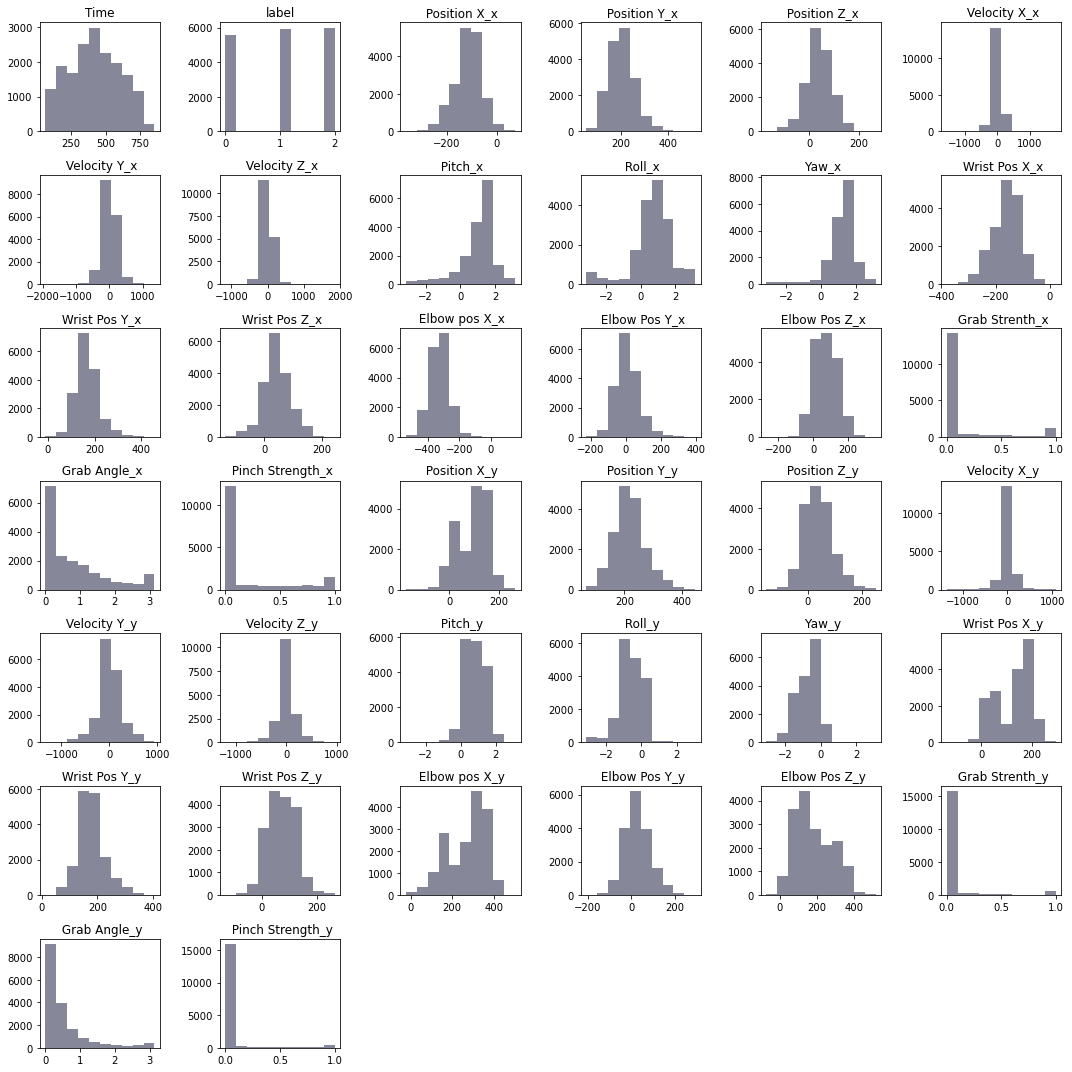

In [15]:
train_data.drop(
    columns=[' Hand Type_x',' Hand Type_y']).hist(stacked=True,
                                                  figsize=(15,15),
                                                  color='#0E1235',
                                                  alpha=0.5,
                                                  grid=False)

plt.tight_layout()
plt.show()

<AxesSubplot:>

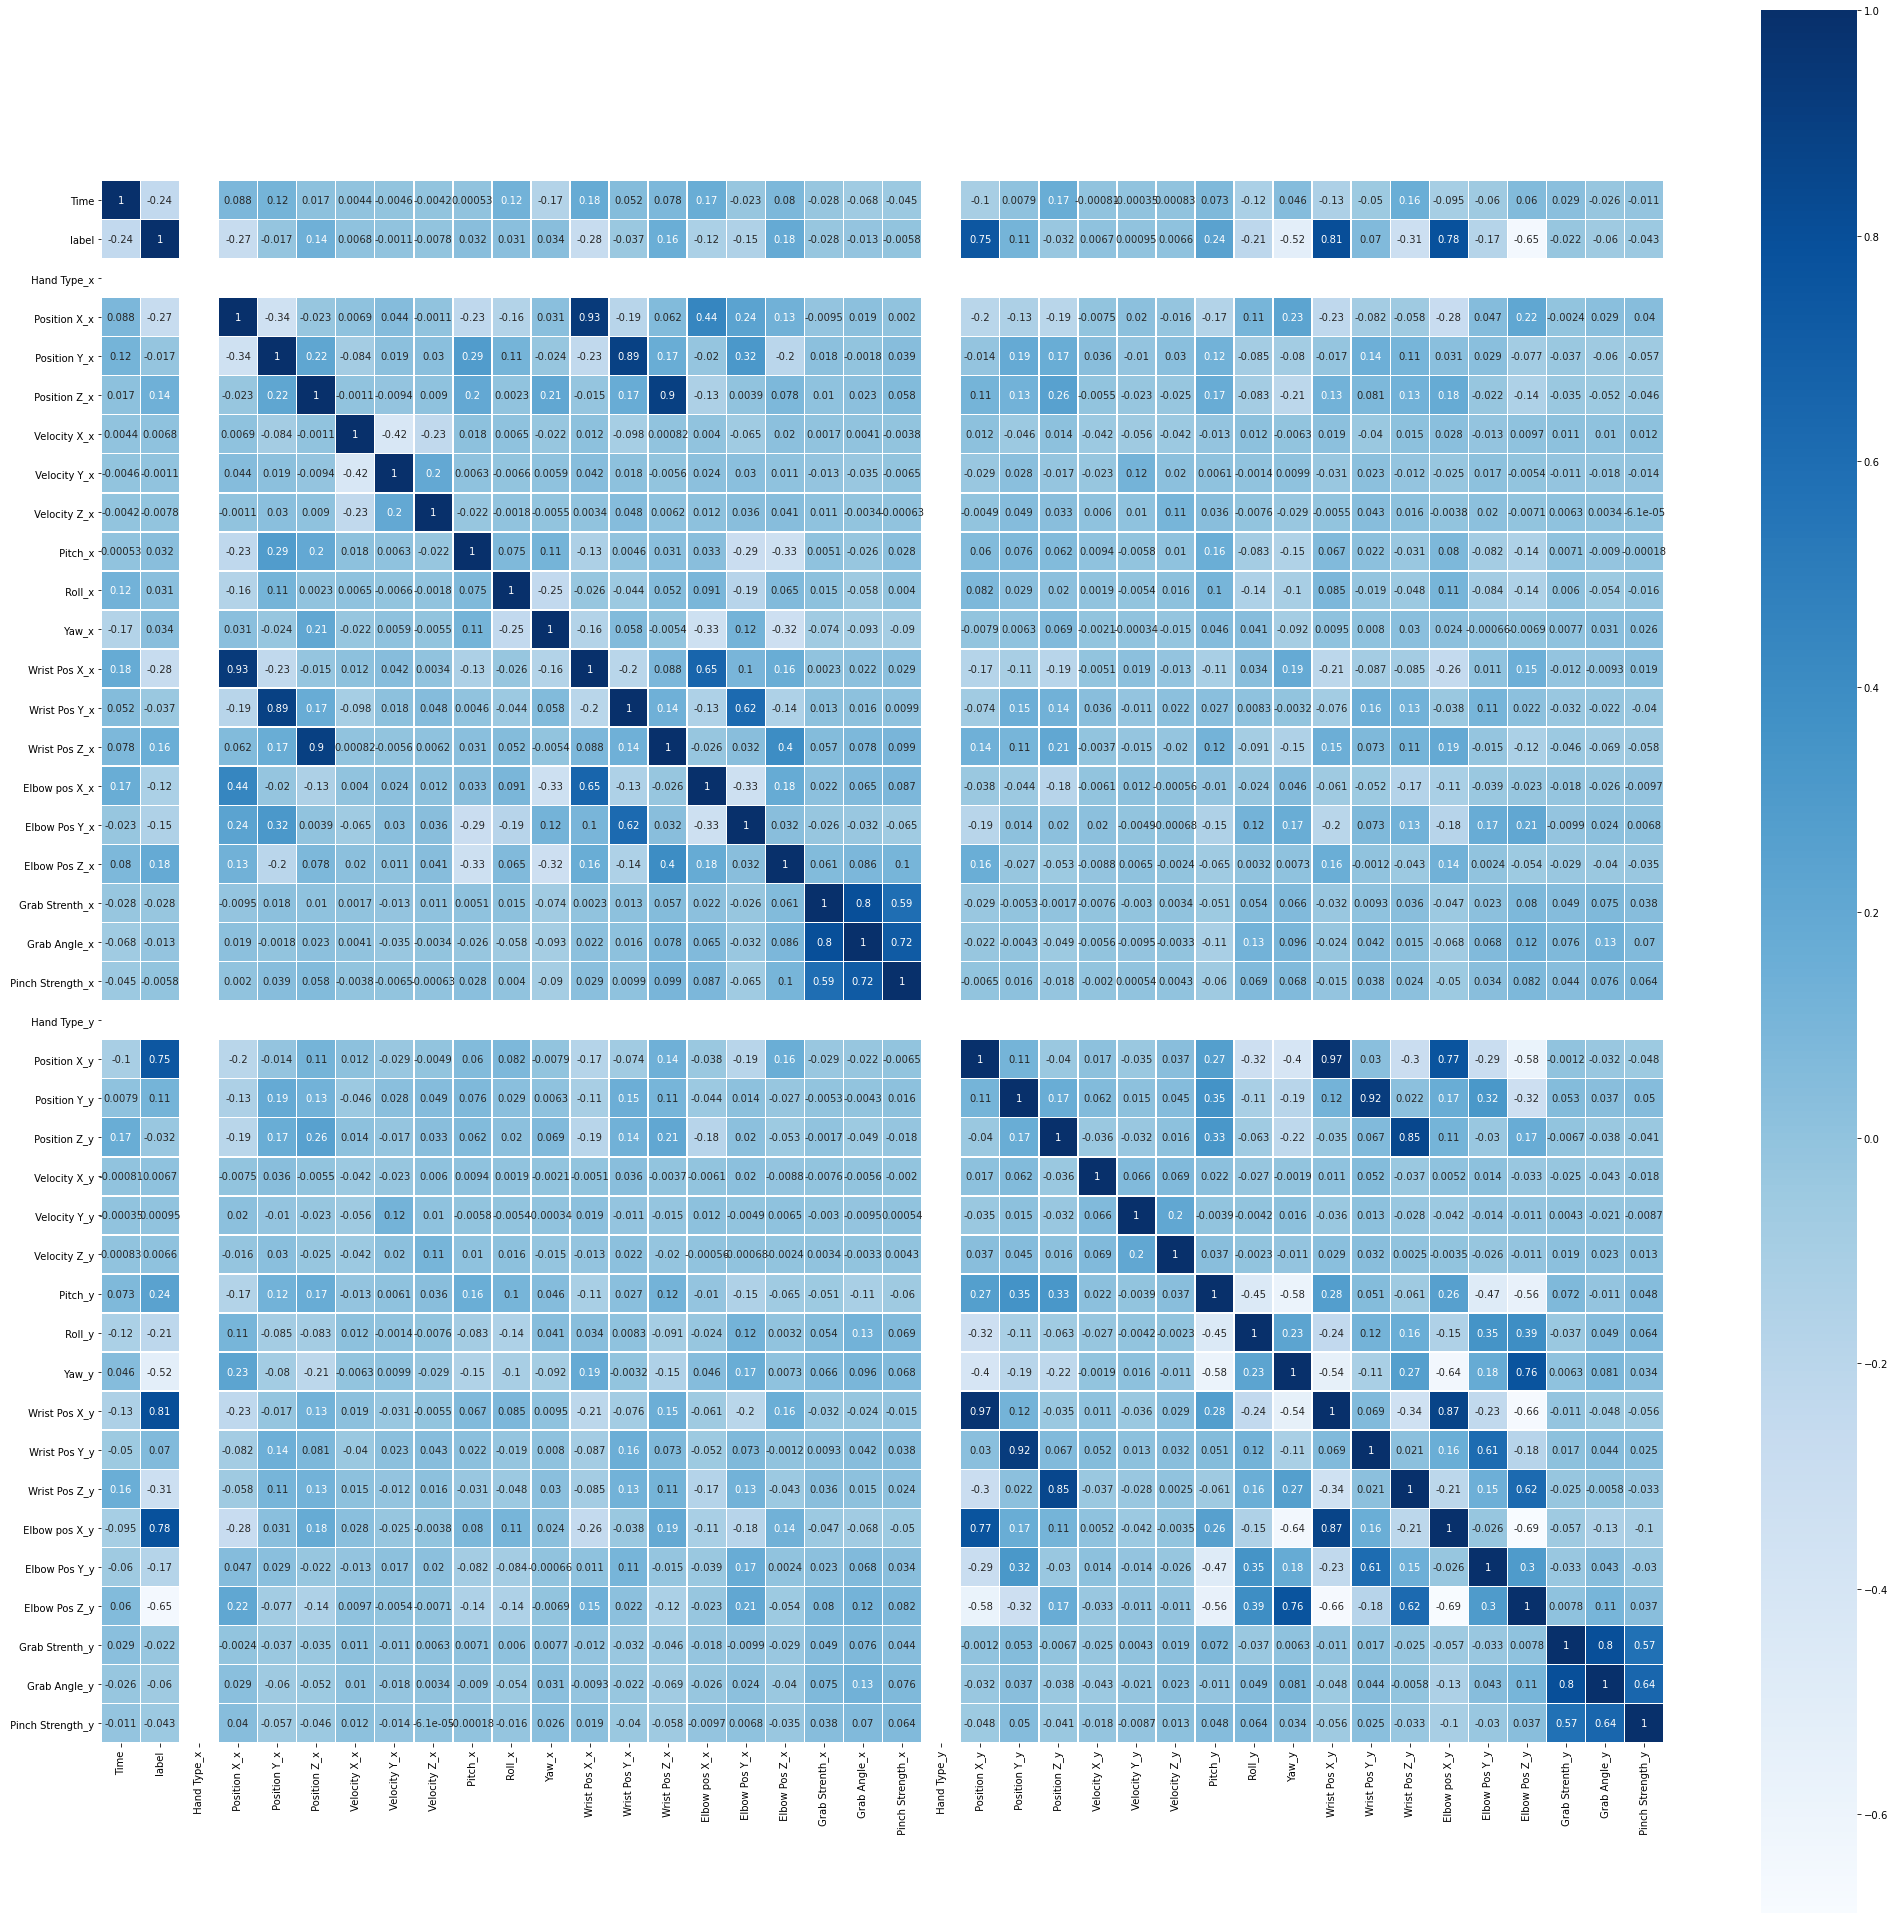

In [16]:
plt.figure(figsize=(35,35))
plt.tight_layout()
sns.heatmap(train_data.corr(), annot=True, cmap="Blues", square=True, linewidths=0.5)

# Classification models:
### Using K-Nearest Neighbors

In [17]:
knn_clf = KNeighborsClassifier(n_neighbors=45, weights='distance')
knn_clf_auc = print_accuracy(knn_clf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1618
           1       0.79      0.91      0.84      1599
           2       0.89      0.76      0.82      1603

    accuracy                           0.89      4820
   macro avg       0.89      0.89      0.89      4820
weighted avg       0.89      0.89      0.89      4820

accuracy of the model is: 88.69 %


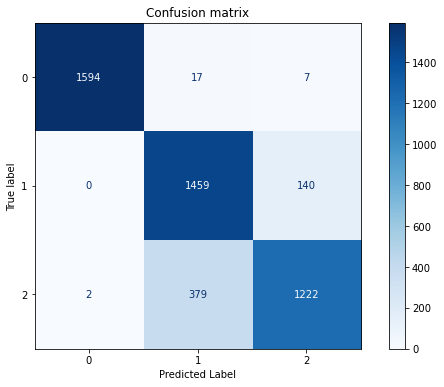

In [18]:
# plot the confusion matrix using the my_plot_confusion_matrix function
my_plot_confusion_matrix(knn_clf, X_test, y_test)

### Using DecisionTree Classifier

In [19]:
dclf = DecisionTreeClassifier()

# print accuracy score
dclf_auc = print_accuracy(dclf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.98      0.71      0.82      1618
           1       0.46      0.77      0.58      1599
           2       0.65      0.40      0.50      1603

    accuracy                           0.63      4820
   macro avg       0.70      0.63      0.63      4820
weighted avg       0.70      0.63      0.63      4820

accuracy of the model is: 62.76 %


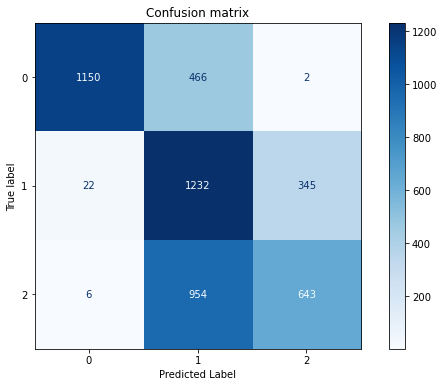

In [20]:
# plot the confusion matrix using the my_plot_confusion_matrix function
my_plot_confusion_matrix(dclf, X_test, y_test)

### Using LogisticRegression Classifier

In [21]:
lclf = LogisticRegression(solver='liblinear')

# print accuracy score
lclf_auc = print_accuracy(lclf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1618
           1       0.71      0.83      0.76      1599
           2       0.80      0.65      0.72      1603

    accuracy                           0.83      4820
   macro avg       0.83      0.83      0.83      4820
weighted avg       0.83      0.83      0.83      4820

accuracy of the model is: 82.86 %


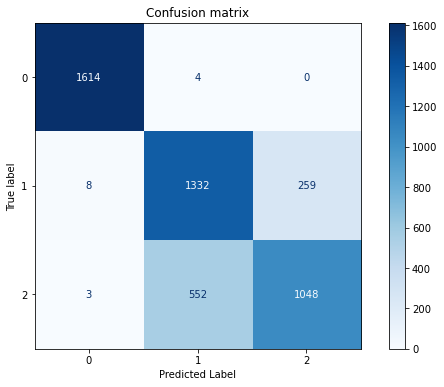

In [22]:
# plot the confusion matrix using the my_plot_confusion_matrix function
my_plot_confusion_matrix(lclf, X_test, y_test)

### Using Bagging Classifier

In [23]:
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)

# print accuracy score
bagging_clf_auc = print_accuracy(bagging_clf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1618
           1       0.73      0.70      0.71      1599
           2       0.77      0.75      0.76      1603

    accuracy                           0.81      4820
   macro avg       0.81      0.81      0.81      4820
weighted avg       0.81      0.81      0.81      4820

accuracy of the model is: 81.06 %


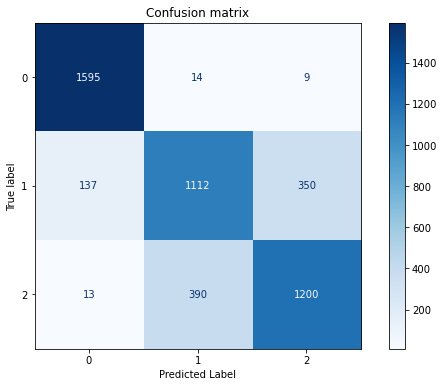

In [24]:
# plot the confusion matrix using the my_plot_confusion_matrix function
my_plot_confusion_matrix(bagging_clf, X_test, y_test)

### Using Pating Classifier

In [25]:
pasting_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=False, n_jobs=-1)

# print accuracy
pasting_clf_auc = print_accuracy(pasting_clf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1618
           1       0.76      0.70      0.73      1599
           2       0.78      0.78      0.78      1603

    accuracy                           0.82      4820
   macro avg       0.82      0.82      0.82      4820
weighted avg       0.82      0.82      0.82      4820

accuracy of the model is: 82.41 %


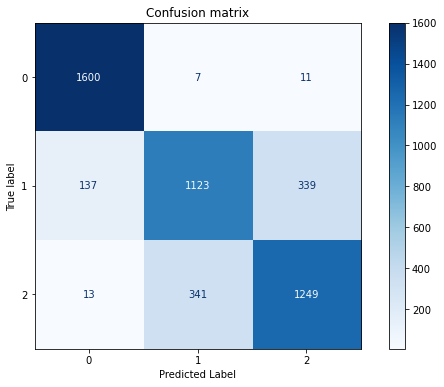

In [26]:
# plot the confusion matrix using the my_plot_confusion_matrix function
my_plot_confusion_matrix(pasting_clf, X_test, y_test)

### Using Random Forest Classifier

In [27]:
rnd_clf = RandomForestClassifier(
    n_estimators=400,
    max_features=5,
    max_depth=16,
    n_jobs=-1)

# print accuracy
rnd_clf_auc = print_accuracy(rnd_clf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1618
           1       0.68      0.85      0.76      1599
           2       0.81      0.60      0.69      1603

    accuracy                           0.82      4820
   macro avg       0.83      0.82      0.81      4820
weighted avg       0.83      0.82      0.81      4820

accuracy of the model is: 81.78 %


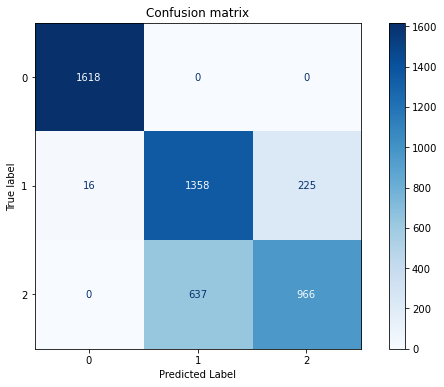

In [28]:
# plot the confusion matrix using the my_plot_confusion_matrix function
my_plot_confusion_matrix(rnd_clf, X_test, y_test)

### Using AdaBoost Classifier

In [29]:
adaboost_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=16),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5)

# print accuracy
adaboost_clf_auc = print_accuracy(adaboost_clf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1618
           1       0.65      0.79      0.71      1599
           2       0.74      0.57      0.64      1603

    accuracy                           0.79      4820
   macro avg       0.79      0.79      0.78      4820
weighted avg       0.79      0.79      0.78      4820

accuracy of the model is: 78.73 %


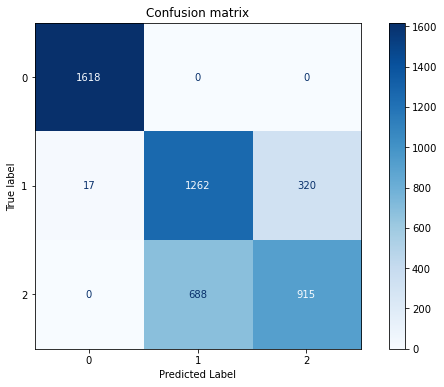

In [30]:
# plot the confusion matrix using the my_plot_confusion_matrix function
my_plot_confusion_matrix(adaboost_clf, X_test, y_test)

### Using Stacking Classifier

In [31]:
stk_clf = StackingClassifier(
        estimators=[
          ('knn', knn_clf ),
          ('ada', adaboost_clf),
          ('bag',bagging_clf)
        ],
    final_estimator=lclf,
    n_jobs=-1)

stk_clf_auc = print_accuracy(stk_clf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1618
           1       0.69      0.85      0.76      1599
           2       0.82      0.62      0.71      1603

    accuracy                           0.82      4820
   macro avg       0.83      0.82      0.82      4820
weighted avg       0.83      0.82      0.82      4820

accuracy of the model is: 82.49 %


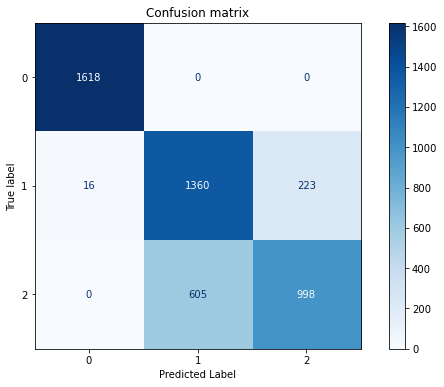

In [32]:
# plot the confusion matrix using the my_plot_confusion_matrix function
my_plot_confusion_matrix(stk_clf, X_test, y_test)

### Using Voting Classifier(hard)

In [33]:
hard_voting_clf = VotingClassifier(
    estimators=[('knn_clf', knn_clf), ('dlf', dclf), ('llf', lclf)],
    voting='hard')
hard_voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('knn_clf',
                              KNeighborsClassifier(n_neighbors=45,
                                                   weights='distance')),
                             ('dlf', DecisionTreeClassifier()),
                             ('llf', LogisticRegression(solver='liblinear'))])

In [34]:
for clf in (knn_clf, dclf, lclf, hard_voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, "{:.2f}".format(accuracy_score(y_test, y_pred) * 100), "%")

KNeighborsClassifier 88.69 %
DecisionTreeClassifier 62.34 %
LogisticRegression 82.86 %
VotingClassifier 83.15 %


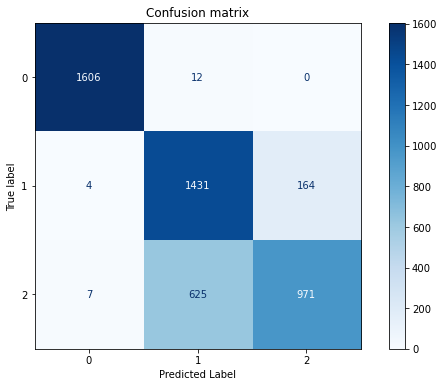

In [35]:
# plot the confusion matrix using the my_plot_confusion_matrix function
my_plot_confusion_matrix(hard_voting_clf, X_test, y_test)

### Using Voting Classifier(soft)

In [36]:
soft_voting_clf = VotingClassifier(
    estimators=[('knn_clf', knn_clf), ('dlf', dclf), ('llf', lclf)],
    voting='soft')
soft_voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('knn_clf',
                              KNeighborsClassifier(n_neighbors=45,
                                                   weights='distance')),
                             ('dlf', DecisionTreeClassifier()),
                             ('llf', LogisticRegression(solver='liblinear'))],
                 voting='soft')

In [37]:
for clf in (knn_clf, dclf, lclf, soft_voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, "{:.2f}".format(accuracy_score(y_test, y_pred) * 100), "%")

KNeighborsClassifier 88.69 %
DecisionTreeClassifier 62.90 %
LogisticRegression 82.86 %
VotingClassifier 77.90 %


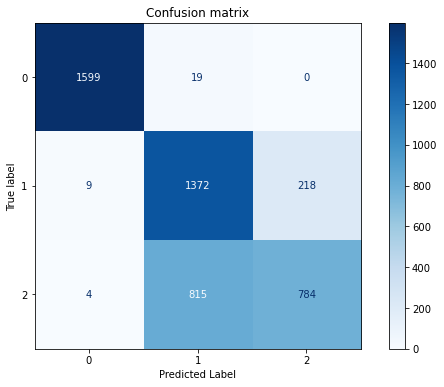

In [38]:
# plot the confusion matrix using the my_plot_confusion_matrix function
my_plot_confusion_matrix(soft_voting_clf, X_test, y_test)

### Using Extreme Gradient Boosting Classifier(Multi)

In [39]:
mul_xgb_model = xgb.XGBClassifier(objective="multi:softmax")

# print accuracy
mul_xgb_model_auc = print_accuracy(mul_xgb_model, X_train, X_test, y_train, y_test)

[14:46:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1618
           1       0.55      0.73      0.63      1599
           2       0.63      0.42      0.50      1603

    accuracy                           0.71      4820
   macro avg       0.72      0.71      0.70      4820
weighted avg       0.72      0.71      0.70      4820

accuracy of the model is: 70.85 %


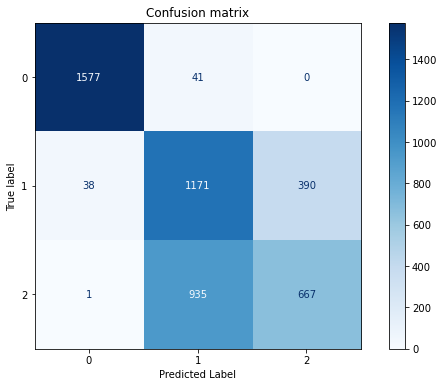

In [40]:
# plot the confusion matrix using the my_plot_confusion_matrix function
my_plot_confusion_matrix(mul_xgb_model, X_test, y_test)

### Using Grid Search with Random Forest Classifier

In [41]:
rnd_clf = RandomForestClassifier().fit(X_train, y_train)

param_values = {'n_estimators' : [10,50,100], 'max_features' : [5,10,20]}
gs_rnd_clf = GridSearchCV(rnd_clf, param_grid=param_values, cv=5, scoring='accuracy')

gs_rnd_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': [5, 10, 20],
                         'n_estimators': [10, 50, 100]},
             scoring='accuracy')

In [42]:
print(gs_rnd_clf.best_params_)
print('accuracy of the model is: {} %'.format("%.2f" % (gs_rnd_clf.best_score_ * 100)))

{'max_features': 5, 'n_estimators': 100}
accuracy of the model is: 86.49 %


### Using Grid Seach with Extreme Gradient Boostring Classifier(Multi)

In [43]:
mul_xgb_model= xgb.XGBClassifier(
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric="mlogloss",
    verbosity=1,
    n_jobs=-1).fit(X_train, y_train)

param_values = {'n_estimators' : [50,100,200], 'max_features' : [5,10,20]}
gs_mul_xgb_model = GridSearchCV(mul_xgb_model, param_grid=param_values, cv=5, scoring='accuracy')

gs_mul_xgb_model.fit(X_train, y_train)

[14:50:05] WARNING: ..\src\learner.cc:541: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:50:07] WARNING: ..\src\learner.cc:541: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:50:09] WARNING: ..\src\learner.cc:541: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:

[14:51:40] WARNING: ..\src\learner.cc:541: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:51:47] WARNING: ..\src\learner.cc:541: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:51:54] WARNING: ..\src\learner.cc:541: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='mlogloss',
                                     gamma=0, gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=1,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,
                                     tree_

In [44]:
print(gs_mul_xgb_model.best_score_,gs_mul_xgb_model.best_params_)

0.8394713541892846 {'max_features': 5, 'n_estimators': 200}


# Conclusions:

In [45]:
classifiers_accuracy = {
    'K-Nearest Neighbors Classifier': knn_clf_auc,
    'Decision Tree Classifier' : dclf_auc,
    'Logistic Regression Classifier' : lclf_auc,
    'Bagging Classifier' : bagging_clf_auc,
    'Pasting Classifier' : pasting_clf_auc,
    'Random Forest Classifier': rnd_clf_auc,
    'AdaBoostring Classifier' : adaboost_clf_auc,
    'Stacking Classifier' : stk_clf_auc,
    'Extreme Gradient Boostring Classifier(Multi)' : mul_xgb_model_auc,
    'Grid Search with Random Forest Classifier' : gs_rnd_clf.best_score_,
    'Grid Seach with Extreme Gradient Boostring Classifier(Multi)' : gs_mul_xgb_model.best_score_
}

In [46]:
for cls in classifiers_accuracy:
    print(cls , ': ', "%.2f" % (100 * classifiers_accuracy[cls]), '%')

K-Nearest Neighbors Classifier :  88.69 %
Decision Tree Classifier :  62.76 %
Logistic Regression Classifier :  82.86 %
Bagging Classifier :  81.06 %
Pasting Classifier :  82.41 %
Random Forest Classifier :  81.78 %
AdaBoostring Classifier :  78.73 %
Stacking Classifier :  82.49 %
Extreme Gradient Boostring Classifier(Multi) :  70.85 %
Grid Search with Random Forest Classifier :  86.49 %
Grid Seach with Extreme Gradient Boostring Classifier(Multi) :  83.95 %


In [47]:
max_accuracy_classifier = max(classifiers_accuracy, key=classifiers_accuracy.get)
print("\nThe classifier with the maximum accuracy is: {}, with the accuracy of: {} %".format(max_accuracy_classifier, "%.2f" % (100 * classifiers_accuracy[max_accuracy_classifier])))


The classifier with the maximum accuracy is: K-Nearest Neighbors Classifier, with the accuracy of: 88.69 %
